# Import the libraries

In [1]:
import os
import sys
sys.path.append("../")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('../data/processed/clean.csv')

In [3]:
# Get a sample of the data
from scripts.manipulation.sampling_data import sampling_data

data_sample = sampling_data(data)

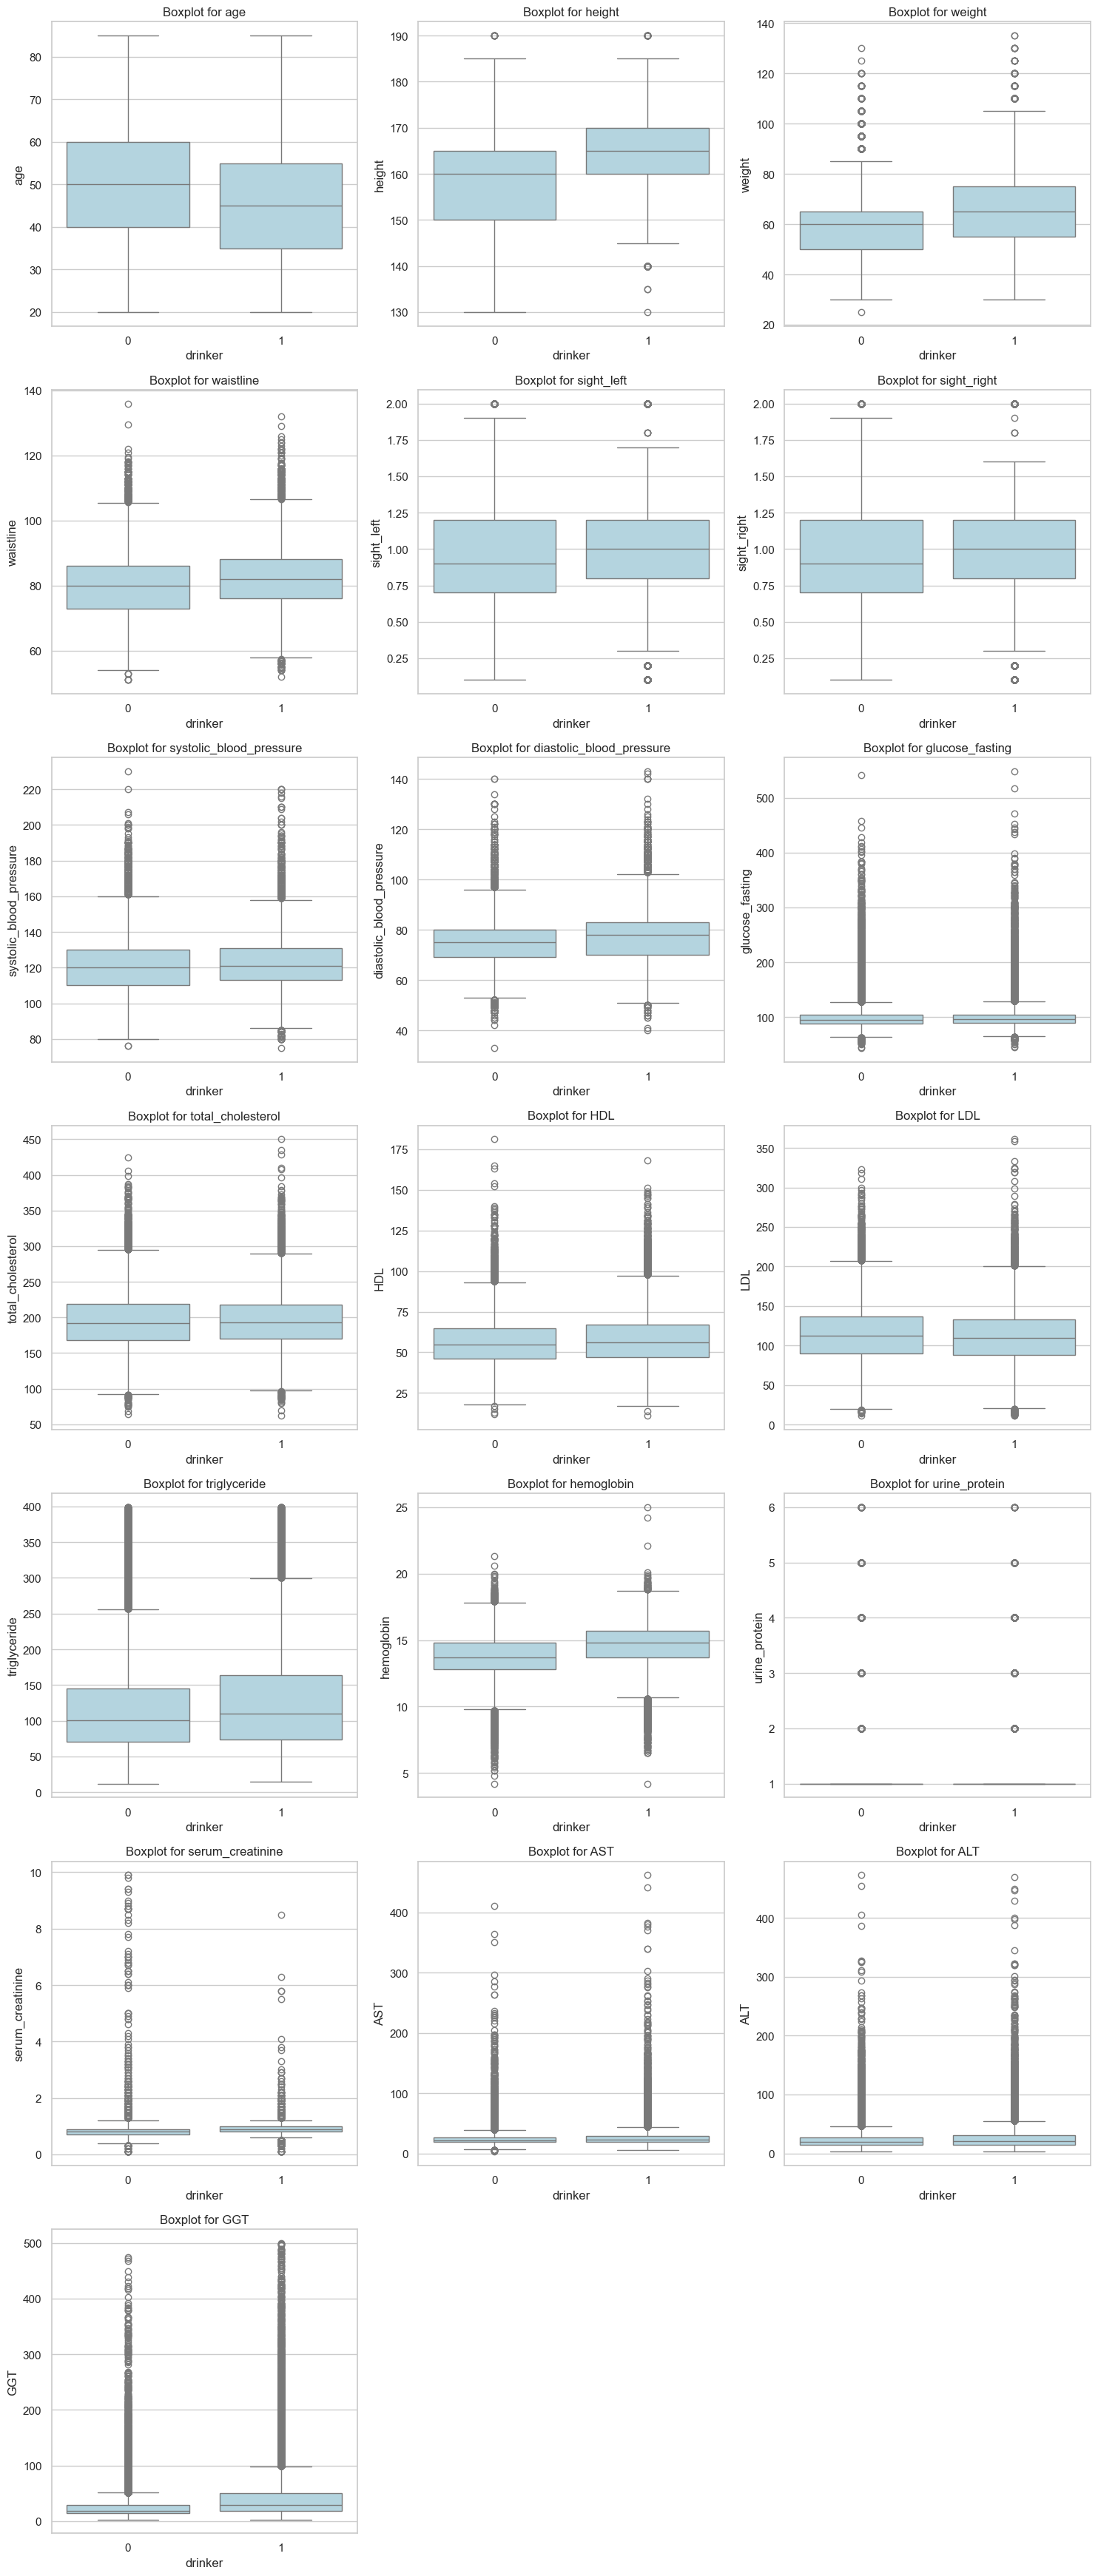

In [4]:
from scripts.visualization.boxplot import boxplot

boxplot(data_sample, hue='drinker')

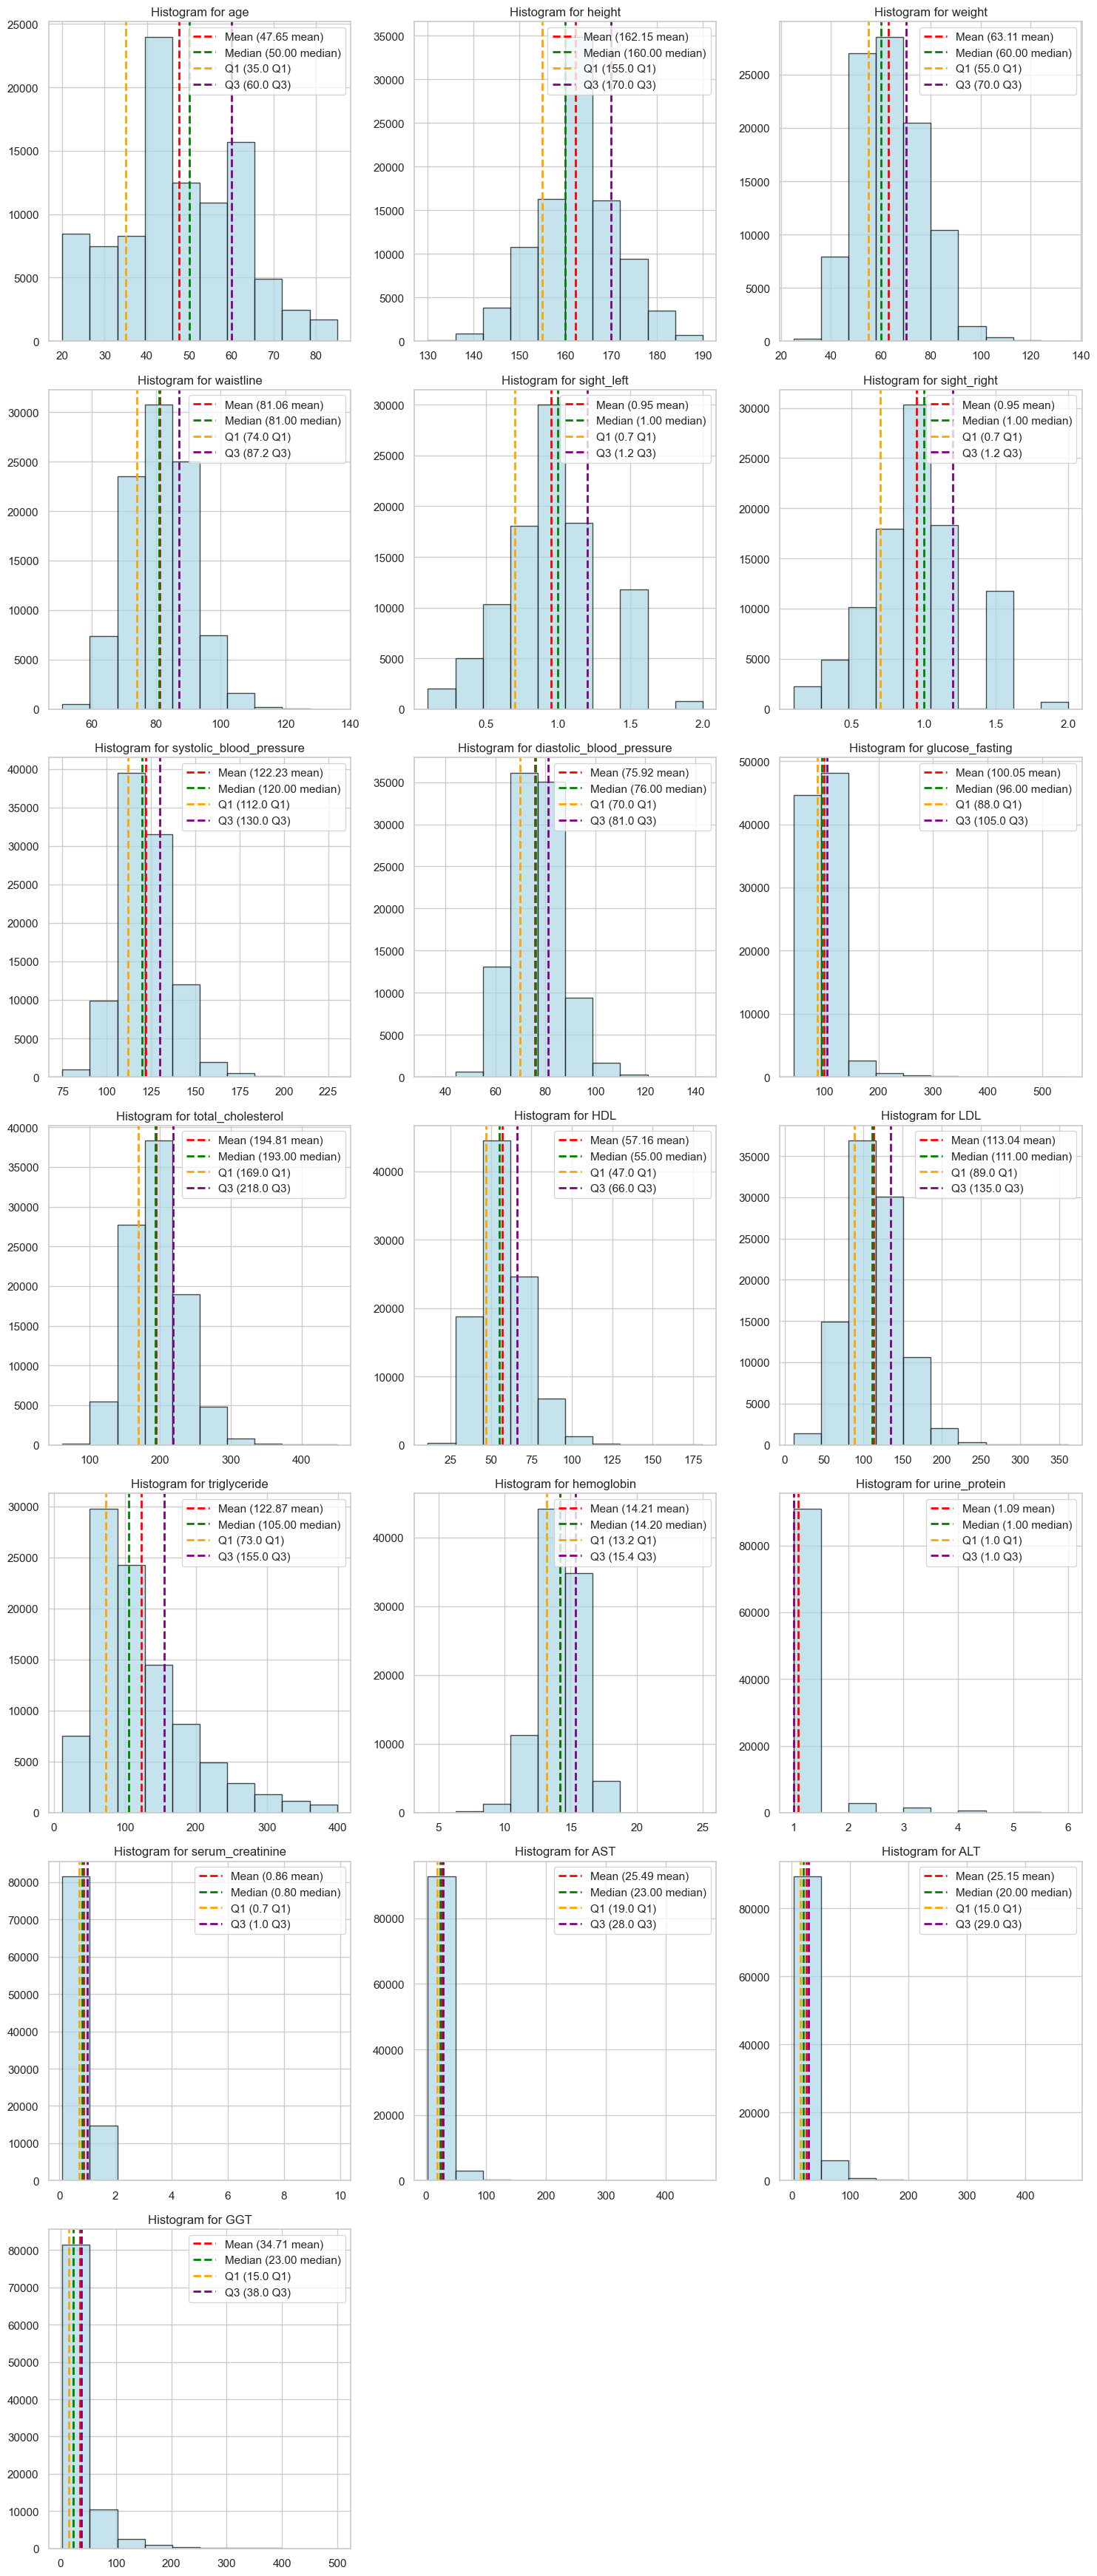

In [5]:
from scripts.visualization.histogram_stats import histogram_stats

histogram_stats(data_sample, n_bins=10)

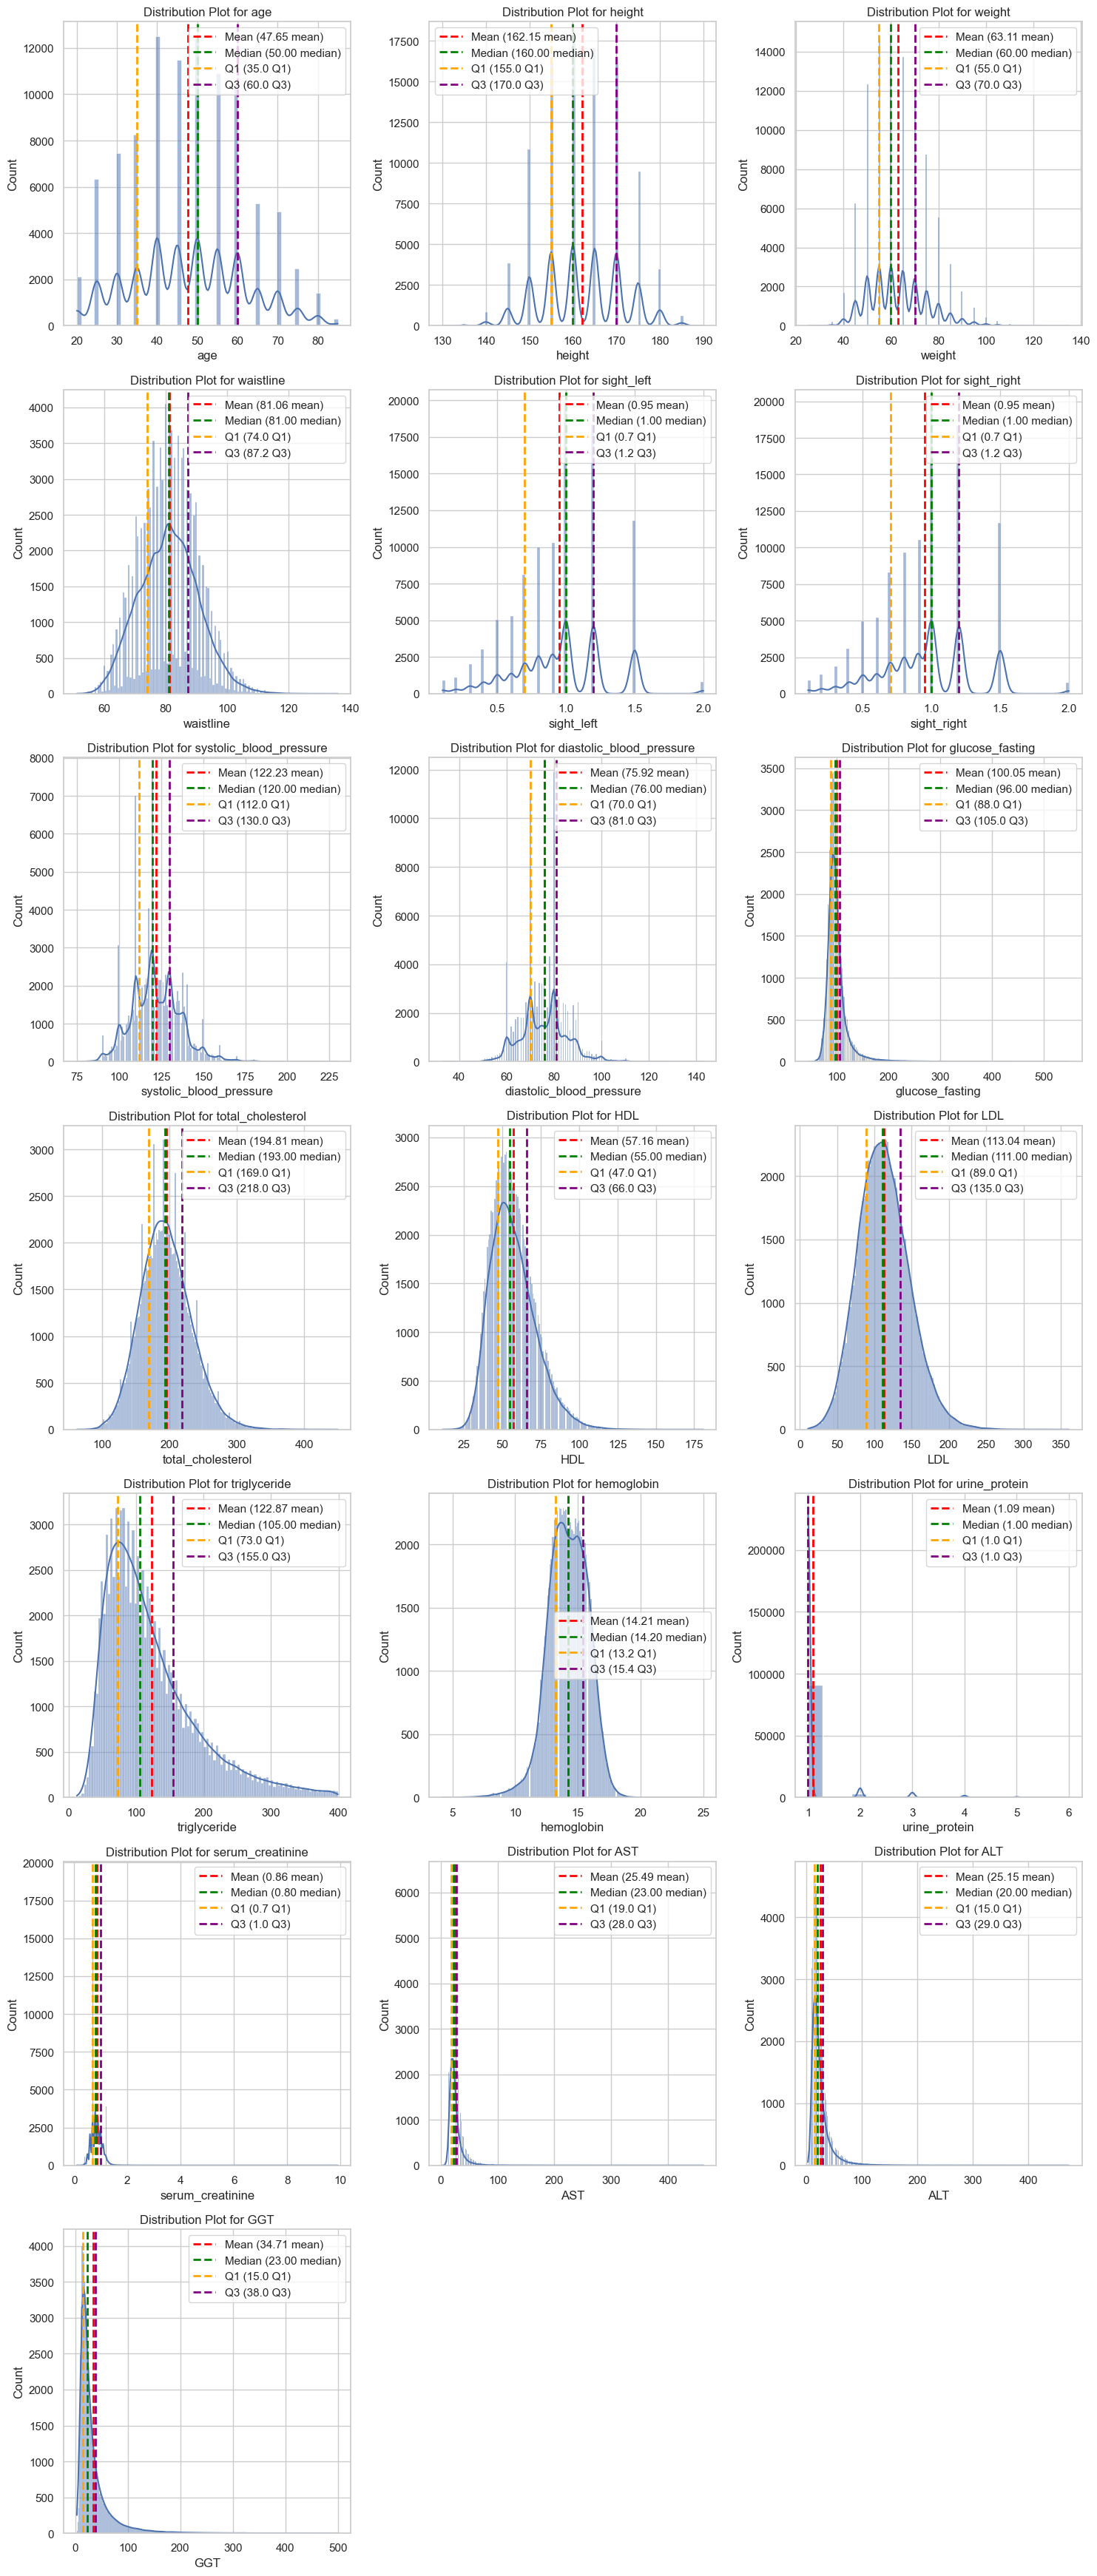

In [6]:
from scripts.visualization.histplot_stats import histplot_stats

histplot_stats(data_sample)

In [7]:
from scripts.visualization.kdeplot import kdeplot

kdeplot(data_sample, hue='drinker')

ImportError: cannot import name 'kdplot' from 'scripts.visualization.kdeplot' (c:\Users\Usuario\OneDrive\Documents\Proyecto\classification_smoker_drinker\notebooks\..\scripts\visualization\kdeplot.py)

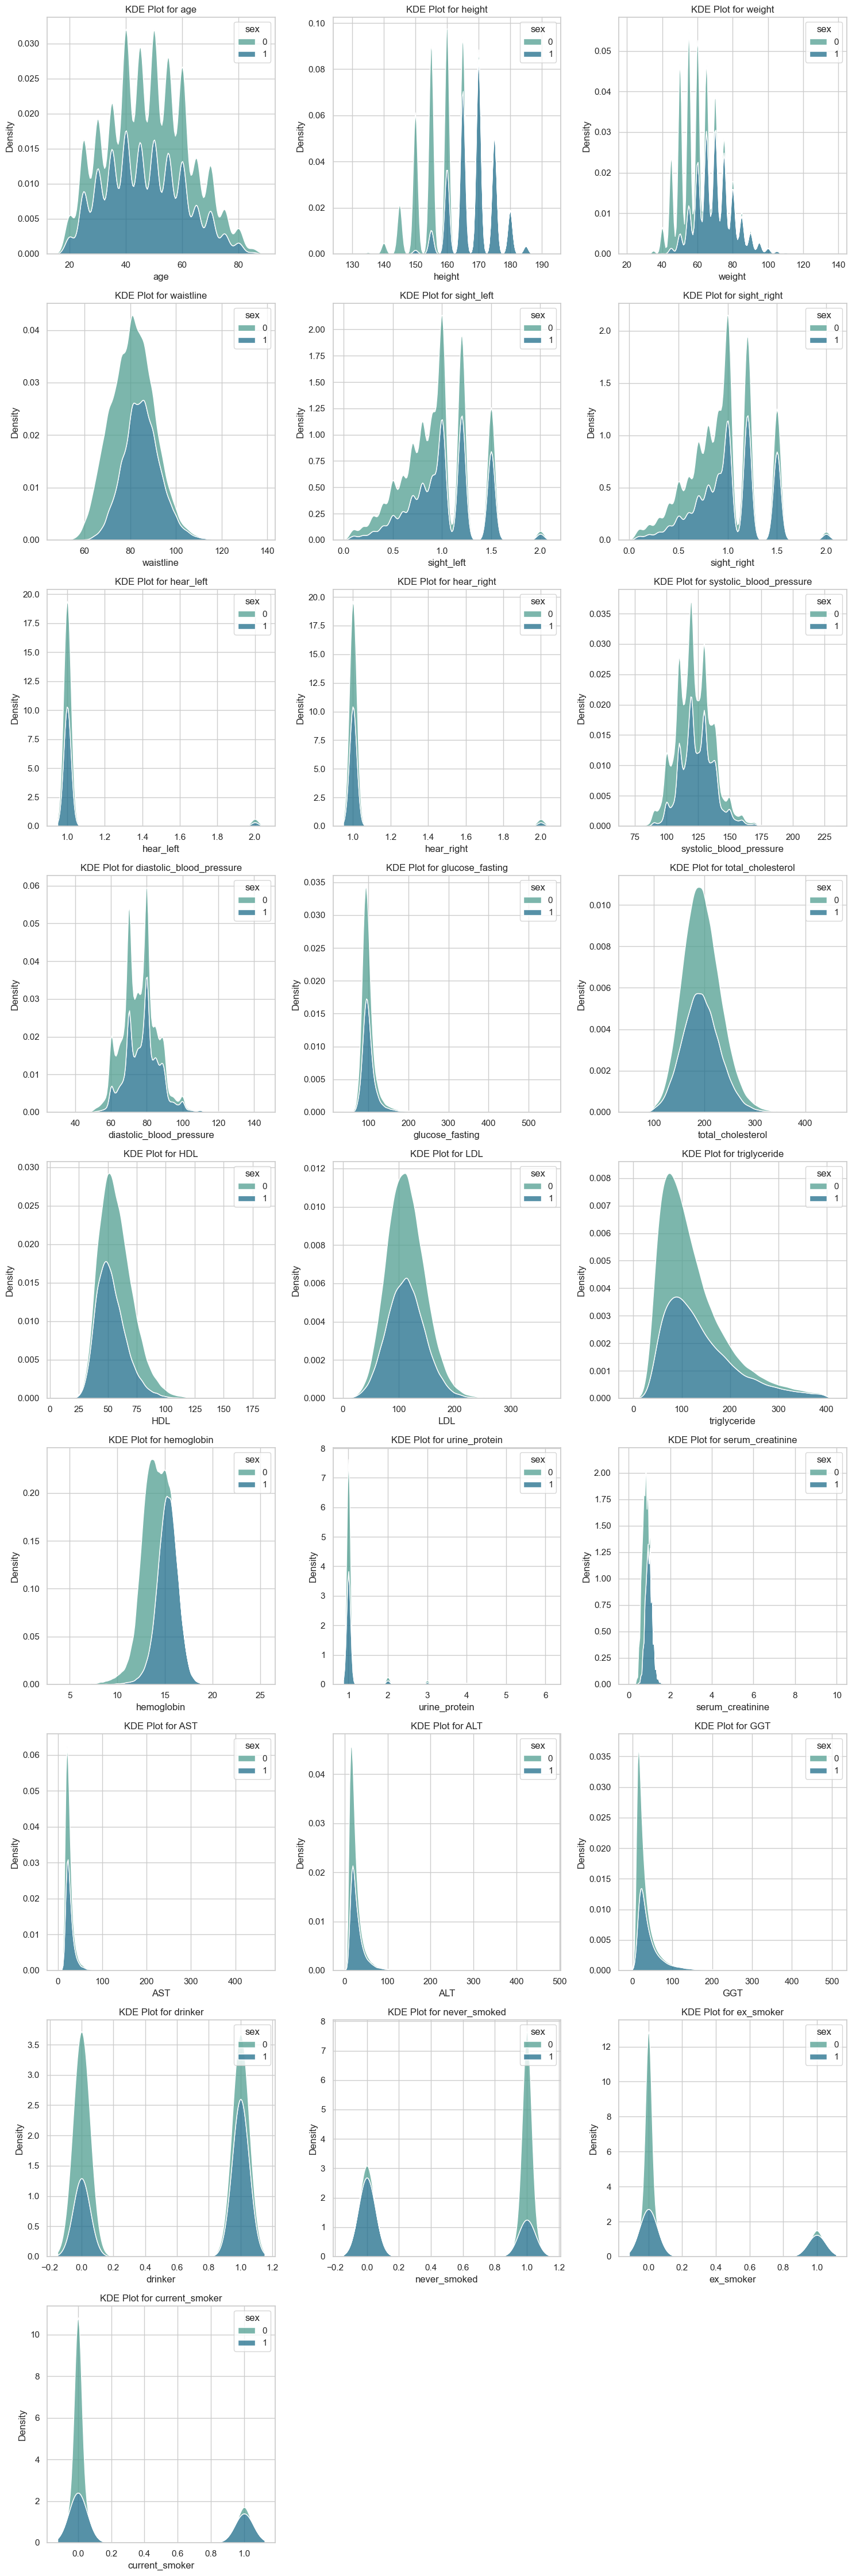

In [ ]:
kdplot(data_sample, hue='sex')

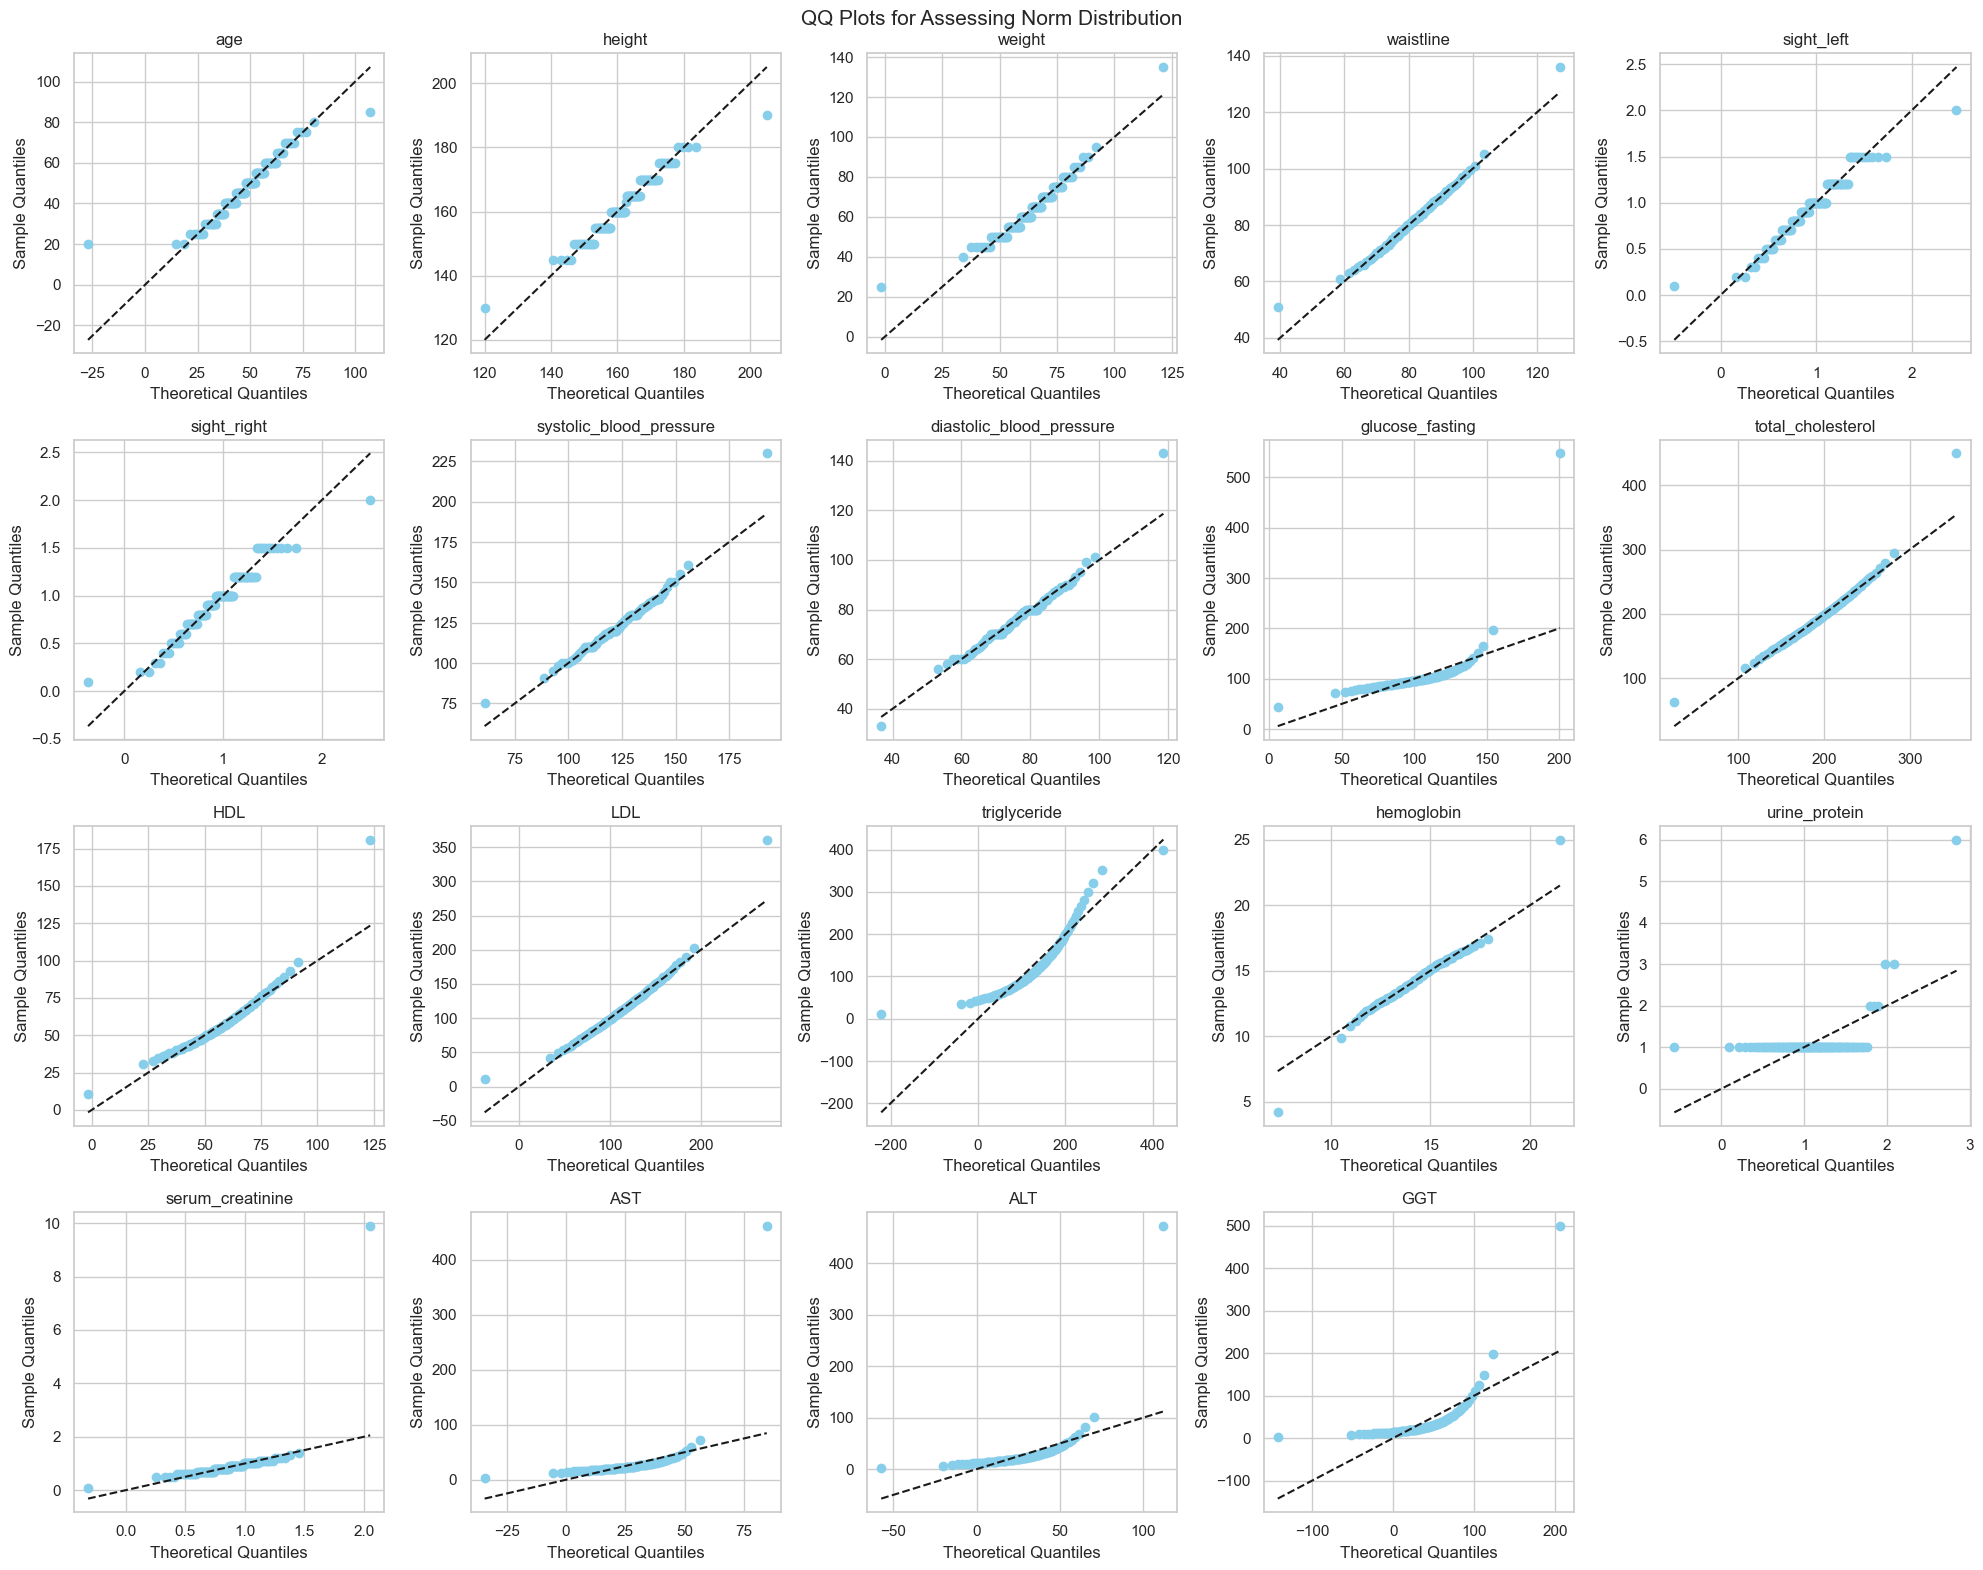

In [ ]:
from scripts.visualization.qq_plot import qq_plots

qq_plots(data_sample, qq_type='norm')

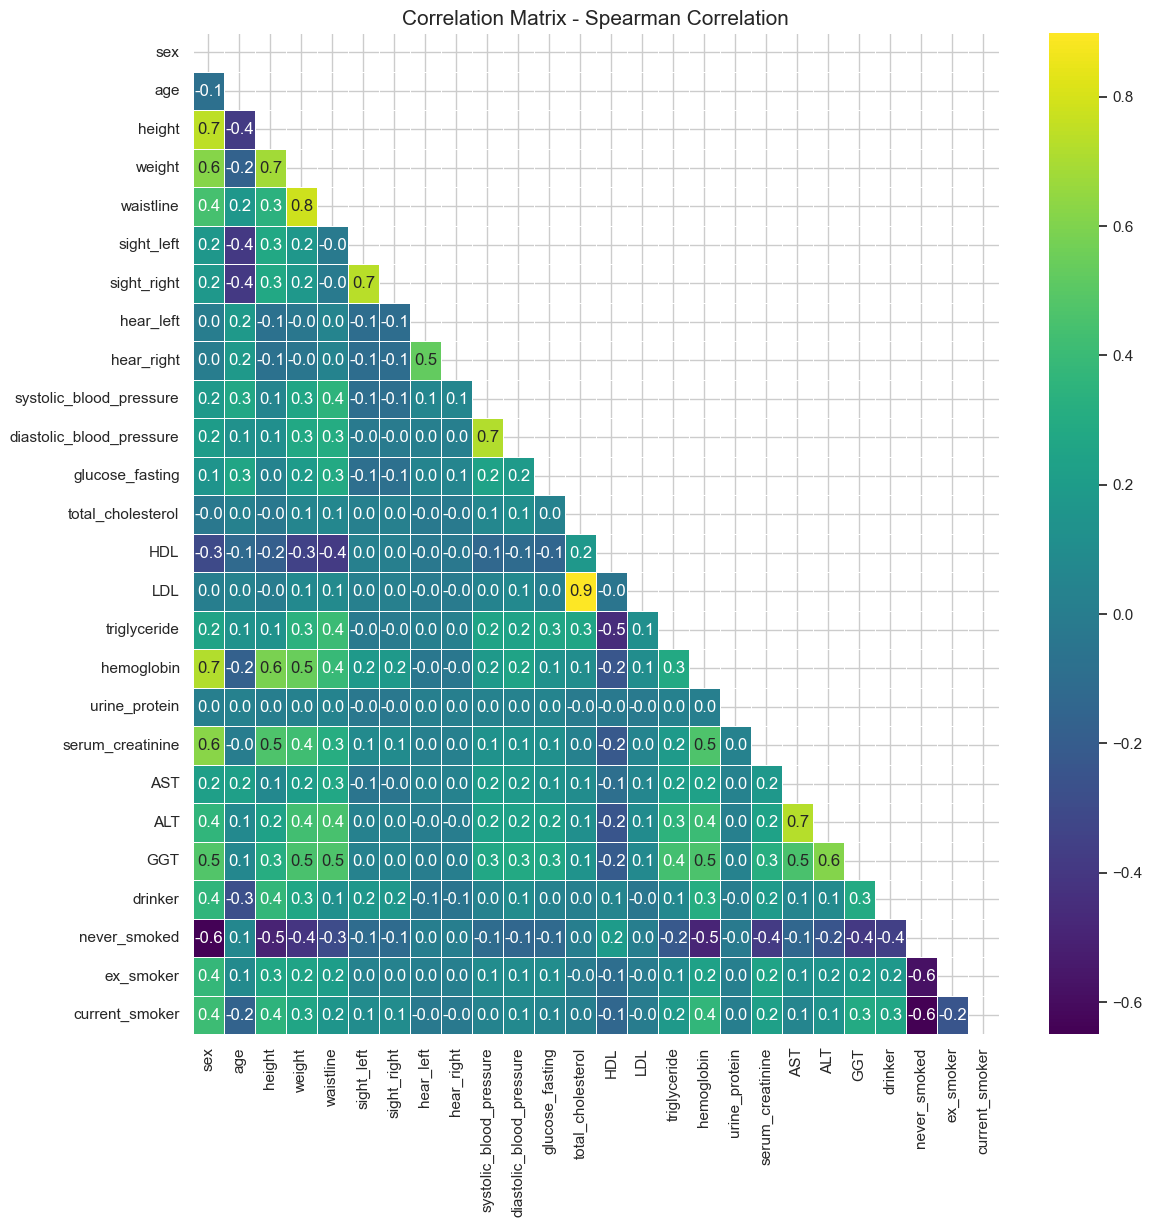

In [ ]:
from scripts.visualization.correlation_matrix import correlation_matrix

correlation_matrix(data_sample, method='spearman')

In [ ]:
data_sample['sex'].value_counts()

sex
1    50777
0    45624
Name: count, dtype: int64

In [ ]:
data_sample['drinker'].value_counts()

drinker
0    48480
1    47921
Name: count, dtype: int64

In [ ]:
# save the data_sample
data_sample.to_csv('../data/processed/data_sample.csv', index=False)

In [44]:
from scripts.manipulation.scale_data import scale_data

data_scaler = scale_data(data_sample, method='standard')

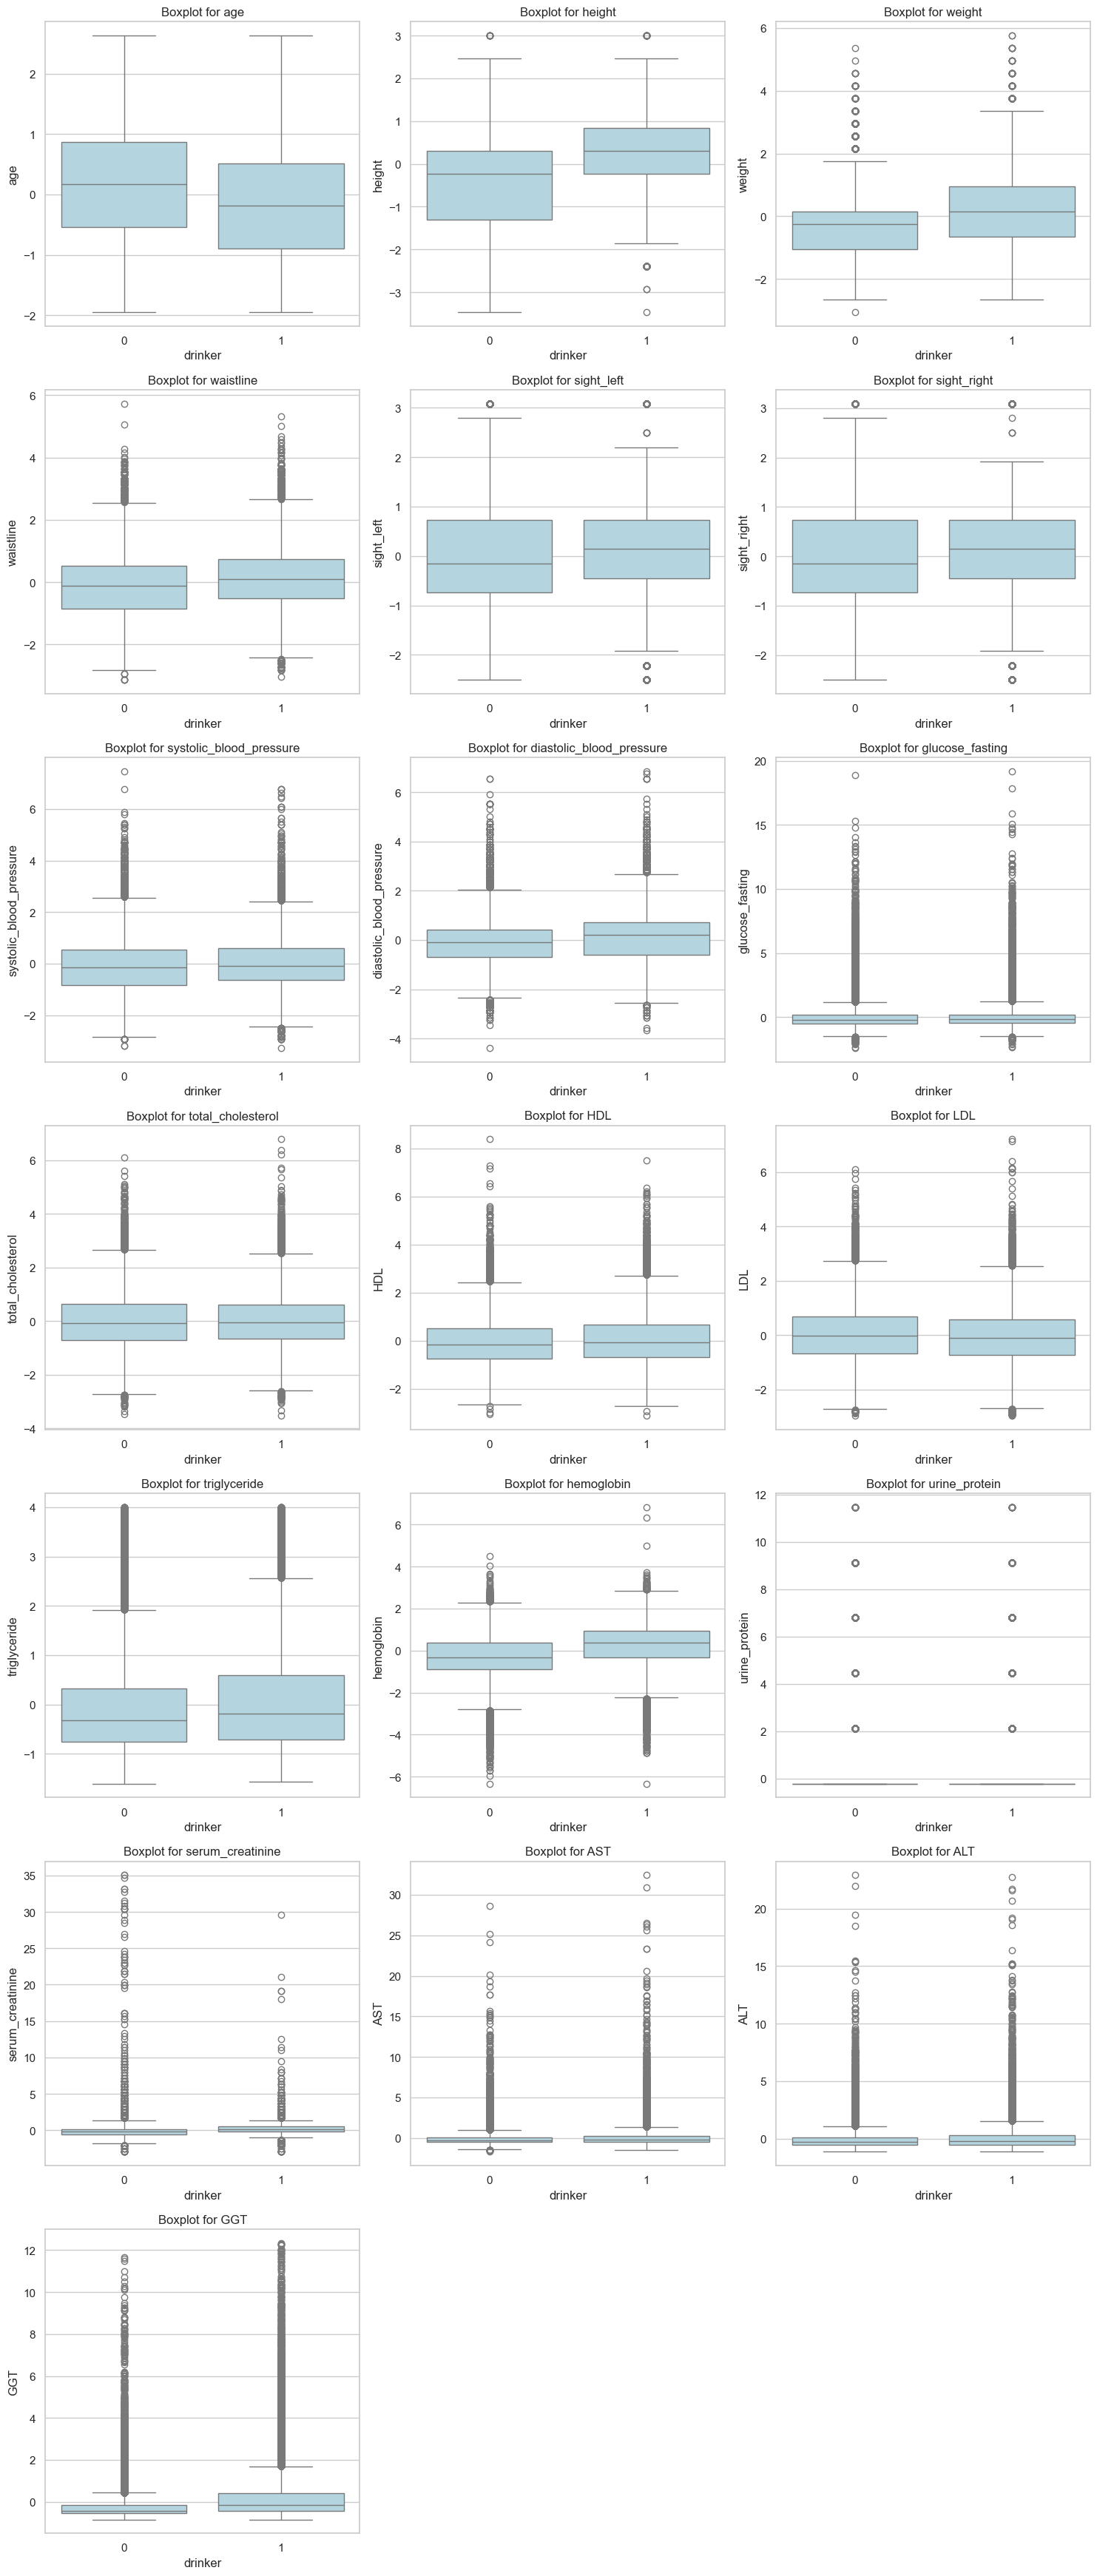

In [45]:
boxplot(data_scaler, hue='drinker')

In [46]:
import numpy as np
import pandas as pd
from scipy.stats import zscore
from scipy.spatial import distance

def detect_outliers(data, method='tukey', k=1.5, mahalanobis_threshold=3):
    """
    Detecta valores atípicos en un DataFrame utilizando el método de Tukey o la distancia de Mahalanobis.

    Parámetros:
    - data (DataFrame): DataFrame que contiene los datos.
    - method (str): Método a utilizar: 'tukey' o 'mahalanobis'. Por defecto, 'tukey'.
    - k (float): Factor para el método de Tukey. Por defecto, 1.5.

    Retorna:
    - outliers_count (Series): Número de outliers detectados para cada columna.
    """

    # Verificar si las columnas son numéricas y no binarias
    numerical_columns = data.select_dtypes(include=[np.number]).columns
    numerical_columns = [col for col in numerical_columns if len(data[col].unique()) > 2]

    # Inicializar el contador de outliers
    outliers_count = pd.Series(0, index=numerical_columns)

    if method == 'tukey':
        for col in numerical_columns:
            q1 = data[col].quantile(0.25)
            q3 = data[col].quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - k * iqr
            upper_bound = q3 + k * iqr

            outliers_count[col] = ((data[col] < lower_bound) | (data[col] > upper_bound)).sum()

    elif method == 'mahalanobis':
        for col in numerical_columns:
            X = data[numerical_columns].values
            cov_matrix = np.cov(X, rowvar=False)
            inv_cov_matrix = np.linalg.inv(cov_matrix)

            for i in range(len(X)):
                mahalanobis_dist = distance.mahalanobis(X[i], np.mean(X, axis=0), inv_cov_matrix)
                if mahalanobis_dist > np.sqrt(mahalanobis_threshold):
                    outliers_count[col] += 1
    print(f'total outliers: {outliers_count.sum()} with {method} method')
    return outliers_count

In [47]:
detect_outliers(data_scaler, method='tukey', k=1.5)

total outliers: 50706 with tukey method


age                            0
height                         7
weight                      1816
waistline                    522
sight_left                   792
sight_right                  730
systolic_blood_pressure     1889
diastolic_blood_pressure    2825
glucose_fasting             5904
total_cholesterol           1182
HDL                         1666
LDL                          983
triglyceride                4020
hemoglobin                   968
urine_protein               5359
serum_creatinine             736
AST                         6077
ALT                         6668
GGT                         8562
dtype: int64

In [48]:

def drop_outliers(data, method='tukey', k=1.5, mahalanobis_threshold=3):
    """
    Elimina los valores atípicos en un DataFrame utilizando el método de Tukey.

    Parámetros:
    - data (DataFrame): DataFrame que contiene los datos.
    - method (str): Método a utilizar: 'tukey' o 'mahalanobis'. Por defecto, 'tukey'.
    - k (float): Factor para el método de Tukey. Por defecto, 1.5.

    Retorna:
    - data (DataFrame): DataFrame sin outliers.
    """

    # Verificar si las columnas son numéricas y no binarias
    numerical_columns = data.select_dtypes(include=[np.number]).columns
    numerical_columns = [col for col in numerical_columns if len(data[col].unique()) > 2]

    if method == 'tukey':
        for col in numerical_columns:
            q1 = data[col].quantile(0.25)
            q3 = data[col].quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - k * iqr
            upper_bound = q3 + k * iqr

            data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]
            
    elif method == 'mahalanobis':
        for col in numerical_columns:
            X = data[numerical_columns].values
            cov_matrix = np.cov(X, rowvar=False)
            inv_cov_matrix = np.linalg.inv(cov_matrix)

            for i in range(len(X)):
                mahalanobis_dist = distance.mahalanobis(X[i], np.mean(X, axis=0), inv_cov_matrix)
                if mahalanobis_dist > np.sqrt(mahalanobis_threshold):
                    data = data.drop(i, axis=0)

    return data

In [49]:
data_clean = drop_outliers(data_scaler, method='tukey', k=1.5)

In [50]:
detect_outliers(data_clean, method='tukey', k=1.5)

total outliers: 6947 with tukey method


age                            0
height                         0
weight                         0
waistline                    112
sight_left                     0
sight_right                    0
systolic_blood_pressure        0
diastolic_blood_pressure       0
glucose_fasting             1180
total_cholesterol            124
HDL                            1
LDL                          140
triglyceride                1457
hemoglobin                    70
serum_creatinine               0
AST                         1045
ALT                          805
GGT                         2013
dtype: int64

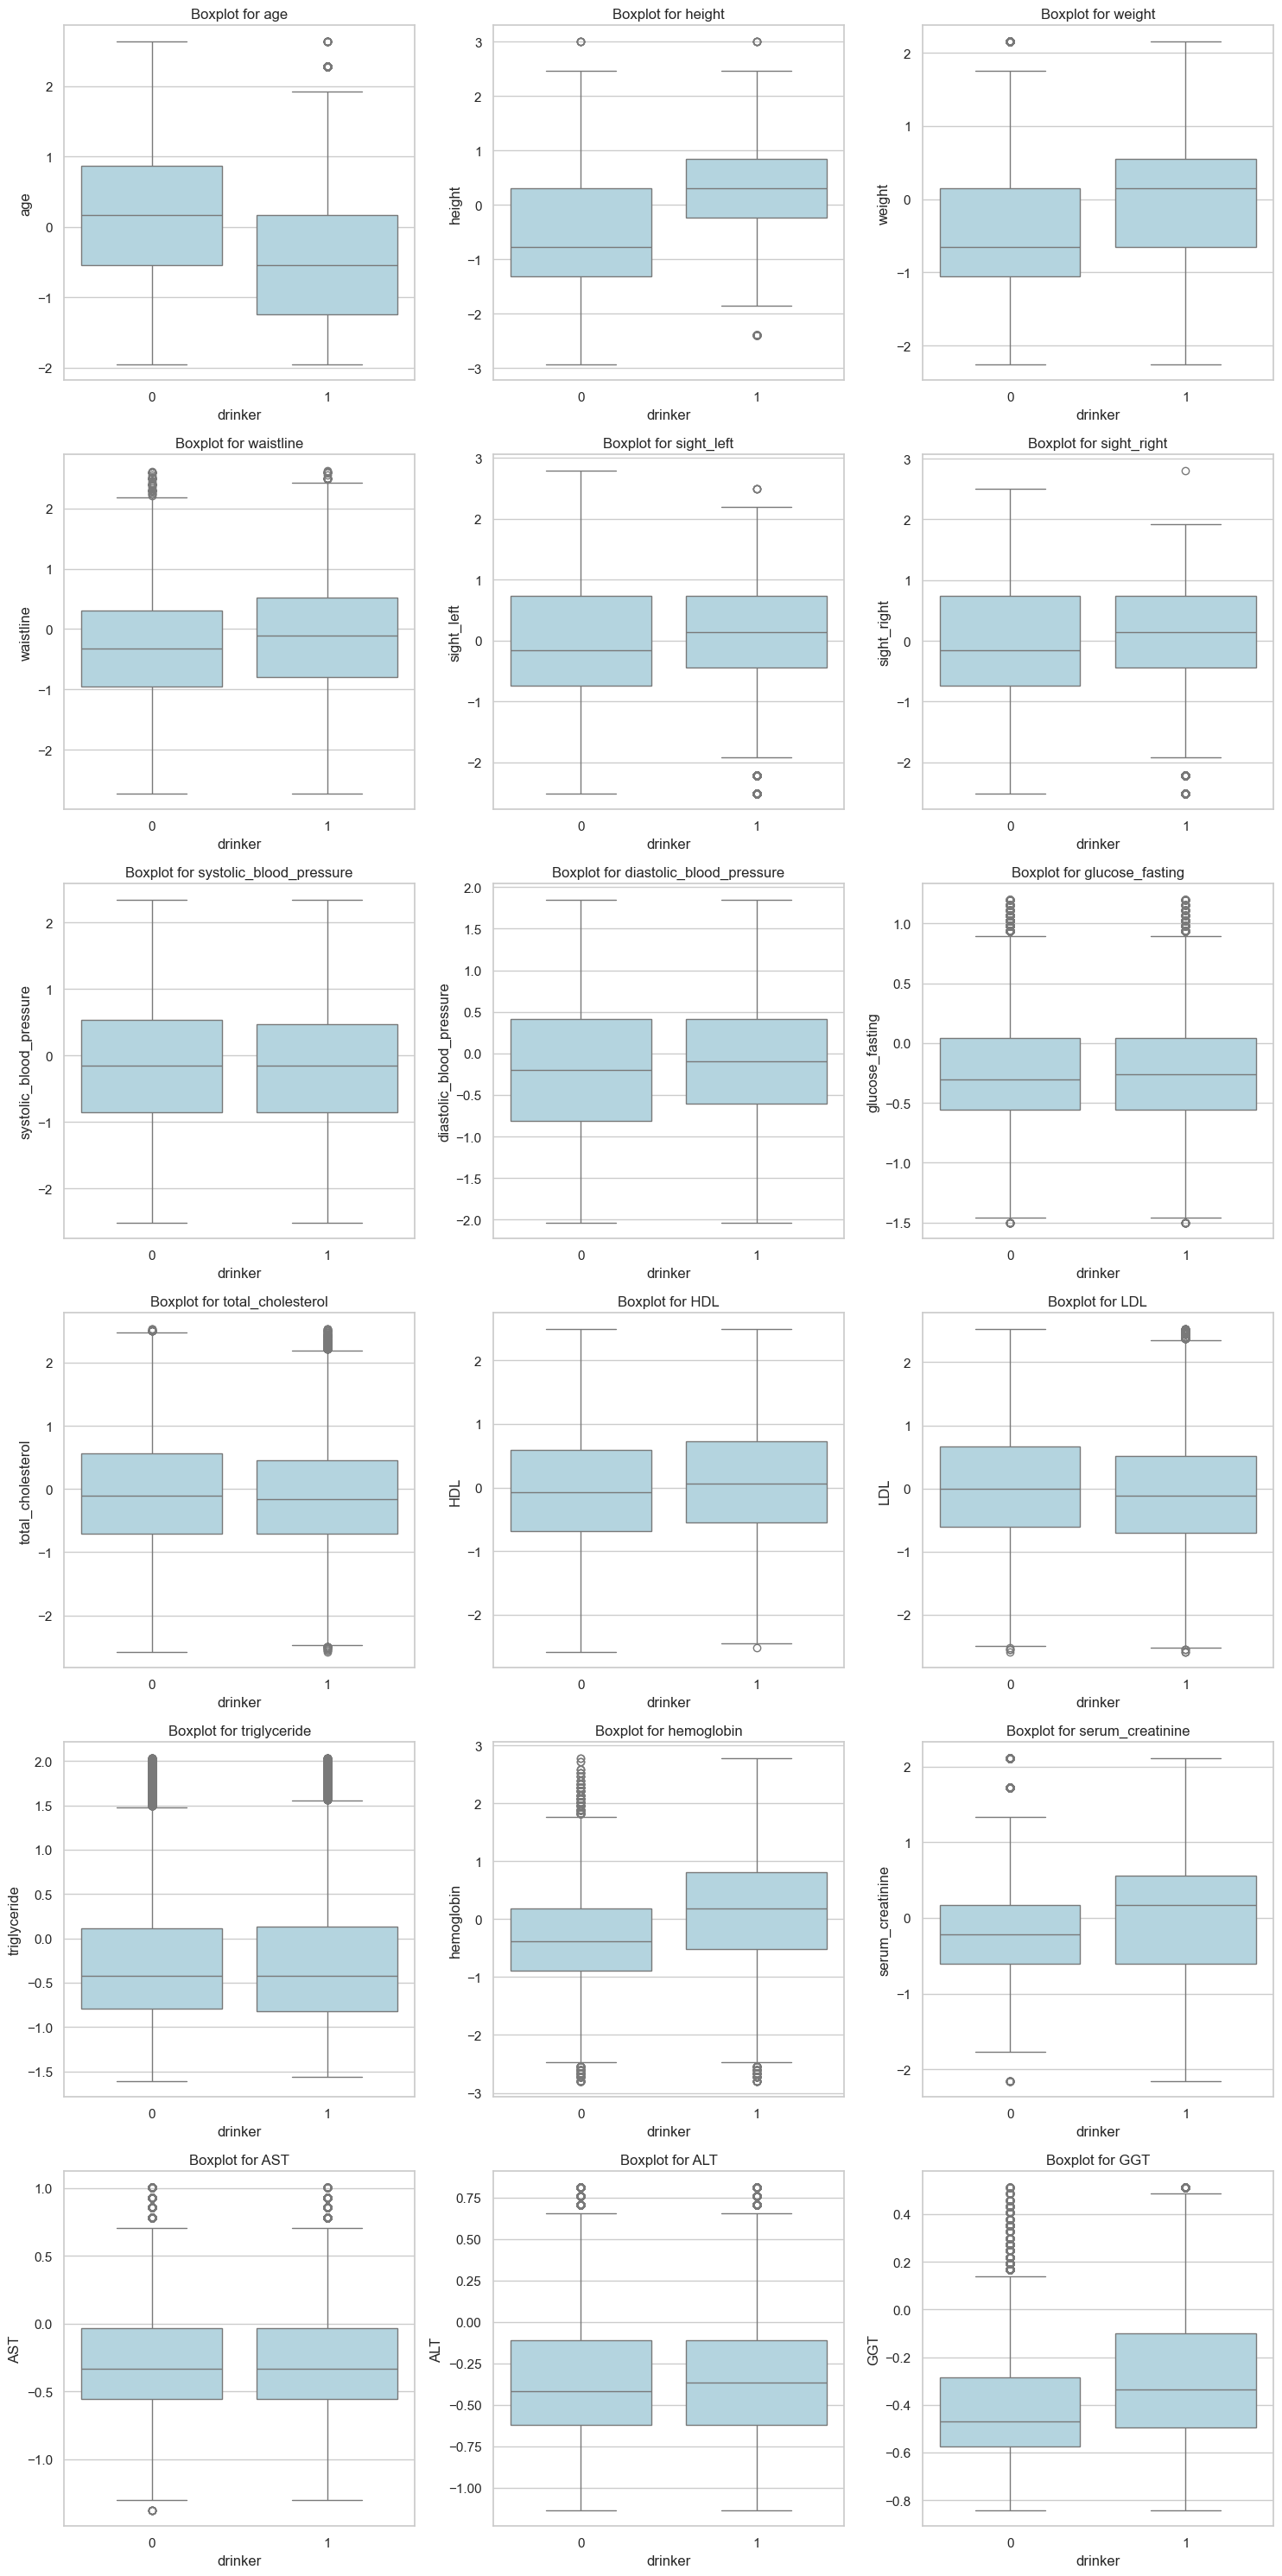

In [51]:
boxplot(data_clean, hue='drinker')

In [53]:
data_reclean = drop_outliers(data_clean, method='tukey', k=1.5)

In [58]:
detect_outliers(data_reclean, method='tukey', k=1.5)

total outliers: 3969 with tukey method


age                           0
height                        0
weight                      395
waistline                    43
sight_left                    0
sight_right                   0
systolic_blood_pressure       0
diastolic_blood_pressure      0
glucose_fasting             478
total_cholesterol            68
HDL                           4
LDL                           0
triglyceride                674
hemoglobin                    0
serum_creatinine            738
AST                         652
ALT                           0
GGT                         917
dtype: int64

In [59]:
data_ultimate_clean = drop_outliers(data_reclean, method='tukey', k=1.5)

In [61]:
data_ultimate_clean

sex       age    height    weight  waistline  sight_left  sight_right  \
695887    0  1.928433 -1.848804 -1.451910  -1.154244   -0.742152    -1.033664   
681412    0 -1.596554  0.306834  1.353364   1.246211    0.730369     0.145948   
203008    1 -1.244055  1.384653  1.754118   1.454946   -0.447648     0.145948   
638858    0 -0.539058  0.306834 -0.650403  -1.206428   -0.153144    -0.148955   
789819    1 -1.596554  1.384653  1.353364   1.037476    0.141361     0.735754   
...     ...       ...       ...       ...        ...         ...          ...   
922621    1 -0.186559  0.306834 -1.051156  -0.820268    0.730369     0.735754   
473742    1 -1.596554  1.384653  0.151104  -0.319303   -0.742152    -1.328567   
326169    1  0.870937  0.306834 -0.249649   0.515638    0.730369    -1.328567   
379103    1 -0.186559  1.384653  1.754118   1.590624   -0.447648     0.735754   
661759    1  0.518438 -0.232075 -0.650403  -0.632406   -0.153144    -0.148955   

        hear_left  hear_right  systolic_blood_pressure  ...  hemoglobin  \
695887        1.0         1.0                 0.745571  ...    0.055524   
681412        1.0         1.0                -0.431671  ...    0.308561   
203008        1.0         1.0                 1.368817  ...    0.245302   
638858        1.0         1.0                -0.708669  ...   -1.146403   
789819        1.0         1.0                 0.745571  ...    0.498339   
...           ...         ...                      ...  ...         ...   
922621        1.0         1.0                -0.223922  ...    0.118783   
473742        1.0         1.0                 0.607072  ...    0.624858   
326169        1.0         1.0                 0.122325  ...    0.688117   
379103        1.0         1.0                -0.847168  ...    1.257451   
661759        1.0         1.0                -0.847168  ...   -0.070995   

        urine_protein  serum_creatinine       AST       ALT       GGT  \
695887      -0.213713         -0.990398 -0.110361 -0.468690 -0.496378   
681412      -0.213713         -1.378076 -0.333261 -0.212653 -0.416791   
203008      -0.213713          0.560313 -0.779060 -0.468690 -0.416791   
638858      -0.213713         -1.378076 -0.556161 -0.775935 -0.655553   
789819      -0.213713          1.335669 -0.036061 -0.212653  0.140320   
...               ...               ...       ...       ...       ...   
922621      -0.213713          0.560313 -0.407561 -0.366276 -0.363733   
473742      -0.213713          0.172635 -0.407561 -0.417483 -0.443320   
326169      -0.213713         -0.602720 -0.481861 -0.468690 -0.257616   
379103      -0.213713          0.947991  0.261138  0.401835  0.087262   
661759      -0.213713          0.560313 -0.704760 -0.673520  0.034204   

        drinker  never_smoked  ex_smoker  current_smoker  
695887        0             1          0               0  
681412        1             1          0               0  
203008        1             0          0               1  
638858        1             1          0               0  
789819        1             0          0               1  
...         ...           ...        ...             ...  
922621        0             1          0               0  
473742        1             1          0               0  
326169        0             0          0               1  
379103        1             0          1               0  
661759        0             0          0               1  

[46937 rows x 26 columns]

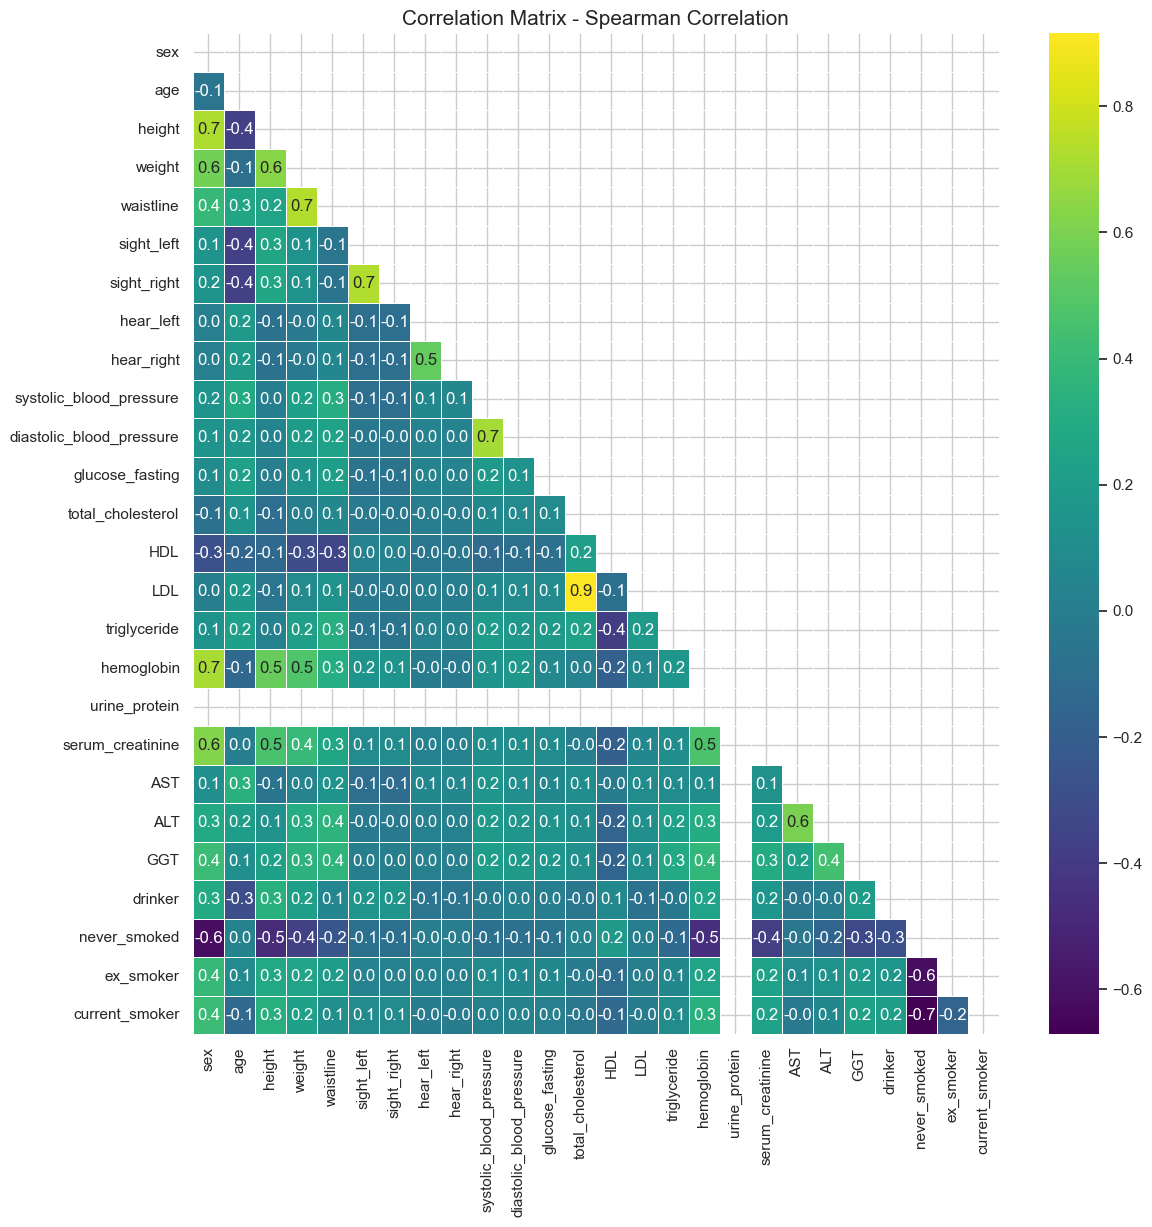

In [63]:
from scripts.visualization.correlation_matrix import correlation_matrix

correlation_matrix(data_ultimate_clean, method='spearman')

In [64]:
data_ultimate_clean.to_csv('../data/processed/data_ultimate_clean.csv', index=False)